In [1]:
import torch
import matplotlib.pyplot as plt
import random


First, we load the words dataset and create char to id and id to char mappings. 

In [2]:
words = open('../l2_makemore/names.txt').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

For this model we will consider the 3 previous characters to predict the next character in a name. As we did in the previous lecture, we can use the '.' character to denote start and end of sequence.

We can print a few examples to see that it works:

In [3]:
block_size = 3

X, Y = [], []

for w in words[:5]:
    context = [0] * block_size
    for c in w + '.':
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
... -----> a
..a -----> v
.av -----> a
ava -----> .
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


Next let's create the embedding vectors. We can first experiment with a smaller size -- I chose 3.

In [4]:
C = torch.randn((27, 3), requires_grad=True)
emb = C[X]
emb.shape

torch.Size([32, 3, 3])

The hidden layer will connect the embeddings to a linear layer, we choose a size of 100 neurons. 

The input size will be the block_size (3) multiplied by the embedding size (also 3) = 9:

In [5]:
W1 = torch.randn((9, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)

In order to feed the embeddings into the hidden layer, we will need to squash the dimensions such that they are of the shape (X, 9) instead of (X, 3, 3) which we can accomplish with the *view* method:

In [6]:
(emb.view(-1, 9) @ W1) + b1

tensor([[-4.0524, -2.8991, -0.4801,  ..., -3.7221,  5.8062, -4.7162],
        [-3.2314, -4.0210,  1.8129,  ..., -2.9598,  3.2823, -5.3950],
        [ 0.3004,  3.0419,  0.9281,  ...,  3.4617,  7.6725, -3.5616],
        ...,
        [-1.5714, -2.8640,  4.8486,  ...,  3.9265,  5.8829,  3.0628],
        [ 2.0637,  2.6813, -1.5872,  ...,  8.1014,  3.7056, -2.3246],
        [-5.3088, -1.4802, -3.5599,  ..., -6.9162, -0.5940, -9.6791]],
       grad_fn=<AddBackward0>)

Finally, the output layer will map the 100 activations from the hidden layer to 27 activations that we will use to represent the probability distribution for each of the 27 possible characters.

In total, the parameters in our network include:
 * embedding weights (C)
 * hidden layer weights (W1)
 * hidden layer biases (b1)
 * output layer weights (W2)
 * output layer biases (b2)

In [7]:
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

We can write a forward propogation function to propogate data through the network. Note that we do not apply an activation to the output layer yet (because we are going to use Cross Entropy Loss! which assumes the values are still logits).

In [8]:
def forward(x, parameters):
    C, W1, b1, W2, b2 = parameters
    emb = C[x]
    h = (emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1) + b1
    h = h.tanh()
    h = (h @ W2) + b2
    return h # returns logits

In [9]:
forward(X, parameters).shape, X.shape

(torch.Size([32, 27]), torch.Size([32, 3]))

Next we can write a function the performs one step of optimization. It feeds some input through the network, computes the cross entropy loss on the output logits, then performs a gradient descent step on all the paramter weights and resets the gradients to 0.

In [10]:
def optimize_step(x, y, parameters, lr=0.1):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item()

We can see that running 2 optimization steps decreases the loss!

In [11]:
optimize_step(X, Y, parameters)

13.095874786376953

In [12]:
optimize_step(X, Y, parameters)

9.901688575744629

Another useful function would be a way to instantiate a network with different layer hyperparamters so that we can easily experiment with different configurations. We can wrap the instantiation of each of the layers in *init_parameters*.

In [13]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size):
    C = torch.randn((num_chars, embedding_size), requires_grad=True)
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size), requires_grad=True)
    b1 = torch.randn(hidden_layer_size, requires_grad=True)
    W2 = torch.randn((hidden_layer_size, num_chars), requires_grad=True)
    b2 = torch.randn(num_chars, requires_grad=True)

    return [C, W1, b1, W2, b2]


In [14]:
parameters = init_parameters(27, 3, 3, 100)

We might want to mess around with changing the block size, so we can create a function that creates input data with a given block size:

In [15]:
def build_inputs_and_labels(words, block_size):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

Additionally, now that we are using a much larger number of paramters, we need to make sure that we don't accidentally overfit to the data we train on. To combat this, we will split the data into a training set, a validation set, and a test set wtih this function:

In [16]:
def train_dev_test_split(words, train_size=0.8, dev_size=0.1):
    random.shuffle(words)
    assert train_size + dev_size < 1
    num_words = len(words)
    train_split = int(num_words * train_size)
    dev_split = int(num_words * (train_size + dev_size))
    train_words = words[:train_split]
    dev_words = words[train_split:dev_split]
    test_words = words[dev_split:]
    return train_words, dev_words, test_words

Now we can split the data and create input tensors for each of the datasets:

In [17]:
train_words, dev_words, test_words = train_dev_test_split(words)

In [18]:
X_train, Y_train = build_inputs_and_labels(train_words, block_size)
X_dev, Y_dev = build_inputs_and_labels(dev_words, block_size)
X_test, Y_test = build_inputs_and_labels(test_words, block_size)

Putting it all together, we can write a gradient descent algorithm. The features include:
* Minibatches: It's very slow to perform a gradient descent step on the entire dataset. Instead, we can samples a subset of the data and perform a gradient descent step on the sample, which should allow us to converge more quickly.
* lr_deacy: Modern optimizers use all sorts of techniques to fine-tune the learning rate during training. For our purposes, we can just apply a decay factor over time s.t. (new lr) = (1 - decay_rate) * old_lr
* Regularization: We can also include a regularization term in the loss function, which will normalize the model's output (by punishing large weights) and help prevent against overfitting. My implementation is very janky but does the job.


In [19]:
def gradient_descent(x, y, parameters, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.001, regularization=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        reg_term = torch.sum(torch.stack([(p**2).sum() for p in parameters])).divide(torch.sum(torch.tensor([p.numel() for p in parameters]))) * regularization
        loss = optimize_step(xi, yi, parameters, lr) + reg_term
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr = lr * (1 - lr_decay)
    return losses
    

On the topic of learning rate decay, we can play around with a learning rate and a decay rate to see how the learning rate changes over time:

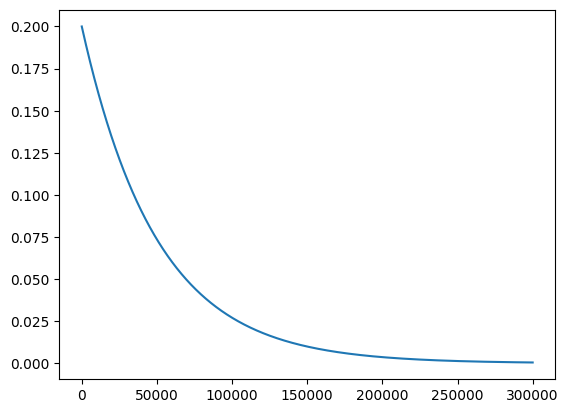

In [20]:
import numpy as np
timesteps=300000
init_lr = 0.2
decay_rate = 0.00002
plt.plot(np.arange(timesteps), [init_lr * ((1 - decay_rate) ** i)for i in range(1, timesteps + 1)])

### E01: 
#### *Tune the hyperparameters of the training to beat my best validation loss of 2.2*

After running many different experiments, I was able to improve upon the results in lecture by increasing the minibatch size, and using learning rate decay to gradually reduce the learning rate over the course of training. I think that using a larger minibatch size resulted in smoother convergence than the size 32 batches we used in lecture, which helped us reach a lower loss value. A smooth learning rate decay curve also likely helped with this:

In [21]:
emb_size = 10
block_size = 3
num_chars = len(chars)
hidden_layer_size = 200
X, Y = build_inputs_and_labels(words, block_size)
parameters = init_parameters(num_chars, block_size, emb_size, hidden_layer_size)
losses = gradient_descent(X_train, Y_train, parameters, iterations=300000, minibatch_size=128, lr=0.2, lr_decay=0.00002, regularization=0.01, print_every=10000)

Iteration 0 loss: 23.31816291809082
Iteration 10000 loss: 2.2284233570098877
Iteration 20000 loss: 2.2406561374664307
Iteration 30000 loss: 2.1608595848083496
Iteration 40000 loss: 2.304851531982422
Iteration 50000 loss: 2.424760341644287
Iteration 60000 loss: 2.4278080463409424
Iteration 70000 loss: 2.20918607711792
Iteration 80000 loss: 2.1471633911132812
Iteration 90000 loss: 2.117159366607666
Iteration 100000 loss: 2.3369579315185547
Iteration 110000 loss: 2.033106803894043
Iteration 120000 loss: 2.0824880599975586
Iteration 130000 loss: 2.192506790161133
Iteration 140000 loss: 2.126777410507202
Iteration 150000 loss: 1.9903192520141602
Iteration 160000 loss: 2.099057674407959
Iteration 170000 loss: 2.306813955307007
Iteration 180000 loss: 2.1502556800842285
Iteration 190000 loss: 2.390268325805664
Iteration 200000 loss: 2.414684772491455
Iteration 210000 loss: 2.091949939727783
Iteration 220000 loss: 1.9811478853225708
Iteration 230000 loss: 2.1161515712738037
Iteration 240000 los

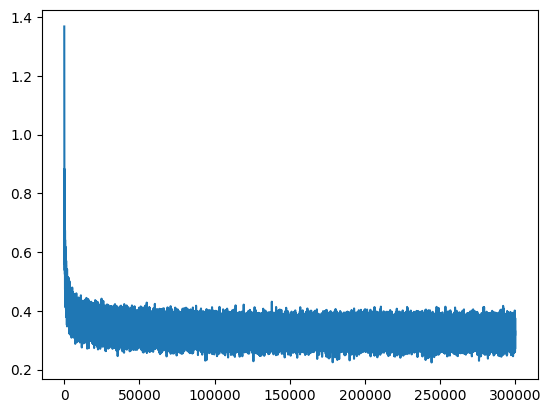

In [22]:
plt.plot(torch.tensor(losses).log10())

We can see that the train and validation losses are both improvements over our results in lecture:

In [23]:
def evaluate(x, y, parameters):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

In [24]:
evaluate(X_train, Y_train, parameters)

2.1127407550811768

In [25]:
evaluate(X_dev, Y_dev, parameters)

2.1731631755828857

Finally, when we try the data on the test set, we acheive a similar result to validation. (If we hadn't we may have accidentally overfit to the validation set via tuning hyperparameters.)

In [26]:
evaluate(X_test, Y_test, parameters)

2.1605467796325684

We can generate some names with the trained model to verify the model works well:

I added some features to the generate function that allows the user to specify a minimum and maximum length!

In [27]:
def generate(parameters, block_size, min_chars=3, max_chars=20):
    C, W1, b1, W2, b2 = parameters
    context = [0] * block_size
    out = []
    for i in range(max_chars):
        logits = forward(torch.tensor([context]), parameters)
        probs = torch.nn.functional.softmax(logits, dim=1)
        if i < min_chars:
            probs[0, 0] = 0
        ix = torch.multinomial(probs, 1).item()
        if ix == 0:
            break
        out.append(itos[ix])
        context = context[1:] + [ix]

    return ''.join(out)

In [28]:
for i in range(20):
    print(generate(parameters, 3))

maemolessahborlealii
gakantt
kalai
pourto
kor
ben
bodiezela
aah
kariis
juliondolian
abduya
jadie
zasenegorowdohy
jmy
sajaochlonilerlin
soleaon
joudmese
selianam
kylenesin
briello


For fun, we can try to generate some really long names:


In [29]:
for i in range(20):
    print(generate(parameters, 3, min_chars=12, max_chars=40))

hasleightstiva
anisondreddiricheston
kayabiyonnaviya
abindieannae
ariowalereth
isynielantanny
siyaannoelynn
zetanellynne
caanayloniah
nahiorington
kaydencortez
kassaromiani
nakalijallyssani
priyamaramylah
zaleelahiminah
ruzifforelon
skenysonstin
muhambrieseranderance
eversiahrocklynn
amperithmaren


### E02: 
#### *I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?*

If the predicted probabilities were perfectly uniform, per the log-likelihood formula the loss would be -log(1/27), given a dataset with 27 characters.

We can verify that this is the case:

In [30]:
y_actual = Y_train[0]
y_actual

tensor(20)

In [31]:
logits = torch.ones(27).divide(27)
logits

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

We'd also apply a softmax activation, but it results in the exact same logits if the logits are all the same.

In [32]:
torch.nn.functional.softmax(logits, dim=0)

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

So it really doesn't matter what value the weights hold. However, the tanh activation is more informative when values are close to zero, so we should strive to keep the weights closer to zero (rather than say, initialize them all to 10000000).

In [33]:
torch.nn.functional.cross_entropy(logits, y_actual)

tensor(3.2958)

In [34]:
import math
-math.log(1/27)

3.295836866004329

Our starting loss is much higher (~23!). To acheive a similar loss, we could make every weight and bias uniform across layers throughout the network. Before, we sampled weights between 0 and 1. To acheive a starting loss of -log(1/27), we can initialize them all to the same value, 0.5 sounds appropriate given that it's in the center of our previous distribution.


In [35]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size):
    C = torch.full((num_chars, embedding_size), 0.5, requires_grad=True)
    W1 = torch.full((embedding_size * block_size, hidden_layer_size), 0.5, requires_grad=True)
    b1 = torch.full((hidden_layer_size,), 0.5, requires_grad=True)
    W2 = torch.full((hidden_layer_size, num_chars), 0.5, requires_grad=True)
    b2 = torch.full((num_chars,), 0.5, requires_grad=True)

    return [C, W1, b1, W2, b2]

In [36]:
new_parameters = init_parameters(num_chars, block_size, emb_size, hidden_layer_size)

In [37]:
new_parameters[0][:3]

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000]], grad_fn=<SliceBackward0>)

And we can verify that we acheive the desired starting loss:

In [38]:
evaluate(X_train, Y_train, new_parameters)

3.295837163925171

### E03: 
#### *Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?*

One idea we could try from the paper is mixing n-gram (in this case, trigram) probabilities with the neural network probabilities to get a final probability, s.t. with each probability having a weight of 0.5. In their results, the network consistently performed better with this technique. The authors suggested that this suggests that the trigram and neural network models tend to make errors in different places.

To acheive this, we can first instantiate and populate a trigram matrix. It's probably prudent just to compute this on the training dataset rather than the entire dataset.

In [39]:
trigrams = torch.zeros((27 * 27), 27)

for word in train_words:
    ids = ([0] * (block_size - 1)) + [stoi[c] for c in word] + [0]
    for i in range(len(ids) - 2):
        trigrams[(ids[i] * 27) + ids[i + 1], ids[i + 2]] += 1

trigrams = (trigrams / trigrams.sum(dim=1, keepdim=True)).nan_to_num(nan=0.0)

Next, we can update the evaluation function to average the network output and the trigram output.

In [40]:
def evaluate(x, y, parameters, trigrams):
    logits = forward(x, parameters) 
    preds = (torch.softmax(logits, dim=1) * 0.5) + (torch.softmax(trigrams[x[:, 1] * 27 + x[:, 2]], dim=1) * 0.5)
    loss = -preds[torch.arange(y.shape[0]), y].log().mean()
    
    return loss.item()

In [41]:
evaluate(X_train, Y_train, parameters, trigrams)

2.382201671600342

In [42]:
evaluate(X_dev, Y_dev, parameters, trigrams)

2.407227039337158

This technique does not improve our model's performance. Perhaps this technique tends to work better on word-level models like in the paper rather than character-level models -- perhaps because the embeddings needed to properly represent a letter are much simpler than those for a word, meaning that ensambling our neural network with the trigram model does not compensate for any of the neural network's error.

We could also try introducing the trigram mixing into our training loop, but I am skeptical:

In [43]:
def optimize_step(x, y, parameters, trigrams, lr=0.1):
    logits = forward(x, parameters)
    preds = (torch.softmax(logits, dim=1) * 0.5) + (torch.softmax(trigrams[x[:, 1] * 27 + x[:, 2]], dim=1) * 0.5)
    loss = -preds[torch.arange(y.shape[0]), y].log().mean()
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item()

def gradient_descent(x, y, parameters, trigrams, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.001, regularization=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        reg_term = torch.sum(torch.stack([(p**2).sum() for p in parameters])).divide(torch.sum(torch.tensor([p.numel() for p in parameters]))) * regularization
        loss = optimize_step(xi, yi, parameters, trigrams, lr) + reg_term
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr = lr * (1 - lr_decay)
    return losses
    

In [44]:
new_parameters = init_parameters(num_chars, block_size, emb_size, hidden_layer_size)
losses = gradient_descent(X_train, Y_train, new_parameters, trigrams, iterations=300000, minibatch_size=128, lr=0.2, lr_decay=0.00002, regularization=0.01, print_every=10000)

Iteration 0 loss: 3.208648443222046
Iteration 10000 loss: 3.071230888366699
Iteration 20000 loss: 2.901762008666992
Iteration 30000 loss: 2.9484827518463135
Iteration 40000 loss: 2.709425449371338
Iteration 50000 loss: 2.8135197162628174
Iteration 60000 loss: 2.920710325241089
Iteration 70000 loss: 2.854020118713379
Iteration 80000 loss: 2.8287267684936523
Iteration 90000 loss: 2.84387469291687
Iteration 100000 loss: 2.765397787094116
Iteration 110000 loss: 2.8810603618621826
Iteration 120000 loss: 2.8022632598876953
Iteration 130000 loss: 2.7869958877563477
Iteration 140000 loss: 2.8552708625793457


KeyboardInterrupt: 

After many iterations with no signs of life, I decided to stop training early.